# Binaryzacja

### Zadanie domowe - binaryzacja adaptacyjna w oknach z interpolacją.

Pokazana w ramach podstawowej części ćwiczenia binaryzacja adaptacyjna działa dobrze, ale jest dość złożona obliczeniowo (choć oczywiście należy mieć świadomość, że implementację można zoptymalizować i wyeliminować pewne powtarzające się obliczenia).
Binaryzację adaptacyjną można również realizować w nieco innym wariancie - w oknach.
Ogólna idea jest następująca: wejściowy obraz dzielimy na nienachodzące (rozłączne) okna - wygodnie jest założyć, że są one kwadratowe i o rozmiarze będącym potęgą liczby 2.
W każdym z okien obliczamy próg - niech to będzie średnia i stosujemy binaryzację lokalną.
Jak nietrudno się domyślić efekt nie będzie dobry, gdyż na granicach okien wystąpią artefakty.
Aby je wyeliminować należy zastosować interpolację, co zostanie szczegółowo opisane poniżej.
Warto zaznaczyć, że podobny mechanizm interpolacji stosowany jest w poznanym wcześniej algorytmie CLAHE.



Na początek zaimplementujemy wariant metody bez interpolacji:
1. Wczytaj obraz _T.png_.
2. W dwóch pętlach `for`, dla okien o ustalonym wymiarze $W$ (potęga 2), oblicz średnią:
- pętle powinny mieć krok $W$,
- wynik należy zapisać w pomocniczej tablicy,

3. W kolejnych dwóch pętlach `for` (o kroku 1) przeprowadź binaryzację z wyznaczonymi progami.
   Wyświetl wyniki - czy jest on poprawny?

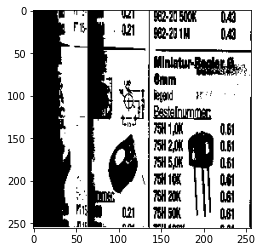

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

#z racji że obraz T.png jest niedostępny użyłem catalogue.png
if not os.path.exists("catalogue.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/catalogue.png --no-check-certificate
        
img = cv2.imread("catalogue.png", cv2.IMREAD_GRAYSCALE)
plt.gray()


X, Y = img.shape
bin_img = np.zeros(img.shape)

W = 64
means= np.zeros((int(X/W)+1,int(Y/W)+1))    

for i in range(0, int(X/W)+1):
    for j in range(0, int(Y/W)+1):
        img_frame = img[ int(i*W) : int((i+1)*W)  , int(j*W) : int((j+1)*W) ]
        means[i,j]= cv2.mean(img_frame)[0]

for i in range(0, X):
    for j in range(0, Y):
        if img[i,j] > means[int(i/W), int(j/W)]:
                bin_img[i,j] = True;
        else:
                bin_img[i,j] = False;
                
bin_img.astype(np.int)

plt.imshow(bin_img)
        

4. Rozwiązaniem problemu artefaktów na obrazie jest zastosowanie interpolacji.
   Próg binaryzacji dla danego okna wyliczany jest na podstawie progów z sąsiednich okien.
   Możliwe są 3 przypadki:
   - piksel leży w rogach obrazu - wtedy za próg przyjmuje się wartość dla danego okna,
   - piksel leży na krawędzi obrazu - wtedy za próg przyjmuje się wartość obliczoną na podstawie dwóch okien,
   - piksel leży w środku - wtedy próg jest obliczany na podstawie 4 sąsiednich okien.
   Uwaga. Proszę to sobie "rozrysować" pamiętając o tym, że dane okno należy podzielić na cztery części (inaczej analiza nie będzie poprawna).

5. Implementujemy interpolację.
   Potrzebujemy do tego znać progi 1-4, ale dla przejrzystości obliczeń lepiej zawsze przyjąć 4 oraz odległości od rozważnego piksela do środka sąsiednich okien (też w ogólnym przypadku 4):
   - całość sprowadza się do określania pozycji piksela,
   - na początek rozważmy przypadek czterech narożników - trzeba napisać `if`, który je wyznaczy,
   - warto sprawdzić, czy nie popełniliśmy błędu i np. tymczasowo do obrazu wynikowego w tym miejscu przypisać wartość 255. Efekt powinien być taki, że widoczne będą tylko narożniki.
   - drugi przypadek do brzegi - postępujemy podobnie jak przy narożnikach, przy czym osobno wydzielamy brzegi pionowe i poziome. Tu też warto sobie obrazek "pokolorować".
   - na koniec wyznaczamy piksele w środku.
   - analizując poprawność proszę zwrócić uwagę na to, żeby nie było przerw pomiędzy obszarami.
   - mając podział możemy dla każdego z obszarów wyliczyć cztery progi ($t11, t12, t21, t22$):
        - dla narożników wartość ta będzie identyczna i wynosi po prostu `t11 =t[jT][iT]`, gdzie `iT=i//W` oraz `jT=j//W`.
          Uwaga. Proszę używać indeksów tymczasowych $jT,iT$, gdyż będą potrzebne w dalszych obliczeniach.
        - dla brzegów pionowych występują dwie wartości: okno bieżące i sąsiednie.
          Wyznaczenie współrzędnej poziomej jest proste (jak dla narożników).
          Nad współrzędną pionową trzeba się chwilę zastanowić - aby nie rozważać wielu przypadków można od bieżącej współrzędnej odjąć połowę rozmiaru okna i dopiero później wykonać dzielenie przez rozmiar okna.
          W ten sposób otrzymujemy indeks okna o mniejszej współrzędnej.
          Indeks drugiego uzyskamy dodając 1.
          Proszę się zastanowić dlaczego to działa.
        - dla brzegów poziomych należy postąpić analogicznie,
        - obliczenia dla obszaru wewnątrz powinny być już oczywiste.
   - kolejny krok to wyliczenie odległości pomiędzy rozważanym pikselem, a czterema środkami.
     Przykładowo dla osi X wygląda to następująco: `dX1 = i - W/2 - iT*W` oraz `dX2 = (iT+1)*W - i-W/2`.
     Dla osi Y analogicznie.
     Ponownie proszę się zastanowić dlaczego to jest poprawne - najlepiej to sobie narysować.
   - ostatni krok to interpolacja dwuliniowa.
     Wykonamy ją w trzech krokach:
     - interpolacja w osi X dla dwóch górnych okien - sprowadza się ona do średniej ważonej pomiędzy wartościami $t11$ i $t12$, przy czym wagi to odpowiednio $dX2/W$ i $dX1/W$.
       Ponownie na podstawie rysunku proszę to przemyśleć.
     - interpolacja w osi X dla dolnych okien jest analogiczna,
     - interpolacja w osi Y również jest analogiczna, z tym, że wejściem są dwa wyniki interpolacji w poziomie.

6. "Kropka nad i" to oczywiście binaryzacja z wyznaczonym poprzez interpolację progiem.

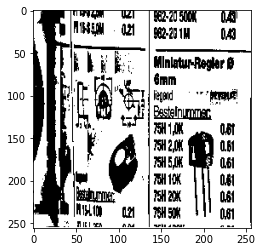

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

if not os.path.exists("catalogue.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/catalogue.png --no-check-certificate
        
img = cv2.imread("catalogue.png", cv2.IMREAD_GRAYSCALE)
plt.gray()

np.seterr
X, Y = img.shape
bin_img = np.zeros(img.shape)

W = 16
means= np.zeros((int(X/W)+1,int(Y/W)+1))
t11, t12, t21, t22 = 0, 0, 0, 0

for i in range(0, int(X/W)+1):
    for j in range(0, int(Y/W)+1):
        img_frame = img[ int(i*W) : int((i+1)*W)  , int(j*W) : int((j+1)*W) ]
        means[i,j]= cv2.mean(img_frame)[0]

for i in range(0, X):
    for j in range(0, Y):
        iT=i//W
        jT=j//W
        dX1 = i + (W/2) - (iT*W)
        dX2 = (W- (i - iT*W) + W/2)
        dY1 = j + W/2 - jT*W
        dY2 = (W- (j - jT*W) + W/2)
        
        if (i//W == 0 and j//W == 0) or (i//W == 0 and j//W == Y//W) or (i//W == X//W and j//W == 0) or (i//W == X//W and j//W == Y//W) : #rogi
            if img[i,j] > means[iT,jT]:
                bin_img[i,j] = True;
            else:
                bin_img[i,j] = False;
                
        elif (i//W==0  and j//W != 0 and j//W != Y//W) or  (i//W==X//W  and j//W != 0 and j//W != Y//W): # boki poziome
            waga_Y1=abs(dY1/W)
            waga_Y2=abs(dY2/W)
            avg= np.average([means[iT,jT-1],means[iT,jT+1]], weights= [waga_Y2, waga_Y1])
            if img[i,j] > avg:
                bin_img[i,j] = True;
            else:
                bin_img[i,j] = False;
                
        elif (j//W==0  and i//W != 0 and i//W != X//W) or  (j//W==Y//W  and i//W != 0 and i//W != X//W): # boki pionowe
            waga_X1=(dX1/W)
            waga_X2=(dX2/W)
            avg= np.average([means[iT-1,jT],means[iT+1,jT]], weights= [waga_X2, waga_X1])
            if img[i,j] > avg:
                bin_img[i,j] = True;
            else:
                bin_img[i,j] = False;
                
        else:
            waga_Y1=(dY1/W)
            waga_Y2=(dY2/W)
            waga_X1=(dX1/W)
            waga_X2=(dX2/W)
            avg= np.average([means[iT,jT-1],means[iT,jT+1],means[iT-1,jT],means[iT+1,jT]], weights= [waga_Y2, waga_Y1, waga_X2, waga_X1])
            if img[i,j] > avg:
                bin_img[i,j] = True;
            else:
                bin_img[i,j] = False;
                
bin_img.astype(np.int)

plt.imshow(bin_img)
